In [1]:
import pandas as pd
import numpy as np 

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import root_mean_squared_error

In [2]:
def bold(text):
    return f"\033[1m{text}\033[0m"

In [3]:
df = pd.read_csv("../data/car_fuel_efficiency.csv")

In [4]:
# Replace with 0 the missing values
df = df.fillna(0)

def split_dataset(dataset, test_size = 0.2, val_size = 0.25, seed = 1):
    train_full_df, test_df = train_test_split(dataset, test_size=test_size, random_state=seed)

    train_df, val_df = train_test_split(train_full_df, test_size=val_size, random_state=seed)

    train_df = train_df.reset_index()
    val_df = val_df.reset_index()
    test_df = test_df.reset_index()

    return train_df, val_df, test_df


train_df, val_df, test_df = split_dataset(df)

In [5]:
y_train = train_df["fuel_efficiency_mpg"]
y_val = val_df["fuel_efficiency_mpg"]
y_test = test_df["fuel_efficiency_mpg"]

del train_df["fuel_efficiency_mpg"]
del val_df["fuel_efficiency_mpg"]
del test_df["fuel_efficiency_mpg"]

In [6]:
dv = DictVectorizer(sparse=True)
X_dict = train_df.to_dict(orient="records")

X_train = dv.fit_transform(X_dict)

In [7]:
X_val = dv.transform(val_df.to_dict(orient="records"))

#### Q1: Decision tree regression - feature importance

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names_out().tolist()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



#### Q2: RMSE for random forest regressor

In [9]:
model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
y_pred = model.predict(X_val)
val_rmse = root_mean_squared_error(y_val, y_pred)
print("The RMSE on the validation dataset:", bold(f"{val_rmse:.3f}"))

The RMSE on the validation dataset: 0.461


#### Q3: Tuning for `n_estimators` parameter

In [11]:
n_estimator_list = np.arange(10, 210, 10)

In [12]:
scores = []

for n_es in n_estimator_list:
    model = RandomForestRegressor(n_estimators=n_es, random_state=1, n_jobs=-1)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    val_rmse = root_mean_squared_error(y_val, y_pred)
    print(f"{'Number of Estimators:':<12}{n_es:<6}  {'Validation RMSE:':<22}{val_rmse:.4f}")

    scores.append((n_es, val_rmse))

Number of Estimators:10      Validation RMSE:      0.4606
Number of Estimators:20      Validation RMSE:      0.4540
Number of Estimators:30      Validation RMSE:      0.4529
Number of Estimators:40      Validation RMSE:      0.4488
Number of Estimators:50      Validation RMSE:      0.4466
Number of Estimators:60      Validation RMSE:      0.4455
Number of Estimators:70      Validation RMSE:      0.4447
Number of Estimators:80      Validation RMSE:      0.4452
Number of Estimators:90      Validation RMSE:      0.4451
Number of Estimators:100     Validation RMSE:      0.4448
Number of Estimators:110     Validation RMSE:      0.4440
Number of Estimators:120     Validation RMSE:      0.4443
Number of Estimators:130     Validation RMSE:      0.4439
Number of Estimators:140     Validation RMSE:      0.4435
Number of Estimators:150     Validation RMSE:      0.4431
Number of Estimators:160     Validation RMSE:      0.4427
Number of Estimators:170     Validation RMSE:      0.4428
Number of Esti

In [25]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores = df_scores.set_index('n_estimators')
df_scores.head(15)

,rmse
n_estimators,
10,0.460633
20,0.454015
30,0.452861
40,0.448787
50,0.446617
60,0.445516
70,0.444692
80,0.445160
90,0.445113


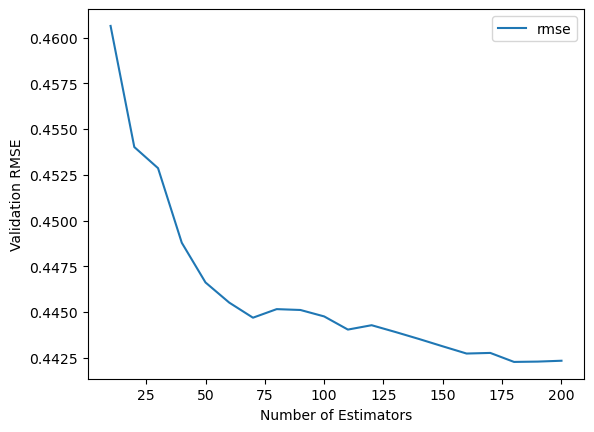

In [33]:
df_scores.plot.line(ylabel="Validation RMSE", xlabel="Number of Estimators");

In [35]:
print(f"Best performance: {df_scores['rmse'].min():.4f} with {df_scores['rmse'].idxmin()} estimators")

Best performance: 0.4423 with 180 estimators


#### Q4: Best `max_depth` parameter

In [16]:
max_depth_list = [10, 15, 20, 25]
n_estimator_list = np.arange(10, 210, 10)

md_scores = {}

for depth in max_depth_list:
    ne_score = []
    for n_es in n_estimator_list:
        model = RandomForestRegressor(max_depth = depth, n_estimators = n_es, random_state = 1, n_jobs = -1)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        val_rmse = root_mean_squared_error(y_val, y_pred)
        ne_score.append(val_rmse)
    md_scores[depth] = [np.mean(ne_score)]

In [17]:
df_scores = pd.DataFrame.from_dict(md_scores, orient='index', columns=['RMSE'])

In [18]:
df_scores

,RMSE
10,0.442942
15,0.445185
20,0.445650
25,0.445843


#### Q5: Feature importance

In [19]:
rfr_params = {'n_estimators': 10, 'max_depth': 20, 'random_state': 1, 'n_jobs': -1}

model = RandomForestRegressor(**rfr_params)

In [20]:
model.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
print("Feature importance: ")
for name, score in zip(dv.get_feature_names_out(), model.feature_importances_):
    print(f"{name}: {score:.4f}")

Feature importance: 
acceleration: 0.0109
drivetrain=All-wheel drive: 0.0003
drivetrain=Front-wheel drive: 0.0003
engine_displacement: 0.0029
fuel_type=Diesel: 0.0003
fuel_type=Gasoline: 0.0003
horsepower: 0.0154
index: 0.0035
model_year: 0.0028
num_cylinders: 0.0020
num_doors: 0.0014
origin=Asia: 0.0004
origin=Europe: 0.0004
origin=USA: 0.0005
vehicle_weight: 0.9586


In [22]:
print("Max feature importance:", bold(f"{dv.get_feature_names_out()[np.argmax(model.feature_importances_)]}"))

Max feature importance: vehicle_weight


#### Q6: `Eta` parameter tuning for XGBoost model

In [23]:
import xgboost as xgb

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [36]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [38]:
eval_scores = {}
model = xgb.train(
    xgb_params, 
    dtrain, 
    evals_result=eval_scores,
    evals=watchlist,
    num_boost_round=100
)


[0]	train-rmse:1.81393	val-rmse:1.85444
[1]	train-rmse:1.31919	val-rmse:1.35353
[2]	train-rmse:0.98120	val-rmse:1.01316
[3]	train-rmse:0.75443	val-rmse:0.78667
[4]	train-rmse:0.60680	val-rmse:0.64318
[5]	train-rmse:0.51381	val-rmse:0.55664
[6]	train-rmse:0.45467	val-rmse:0.50304
[7]	train-rmse:0.41884	val-rmse:0.47228
[8]	train-rmse:0.39526	val-rmse:0.45492
[9]	train-rmse:0.38018	val-rmse:0.44539
[10]	train-rmse:0.37063	val-rmse:0.43961
[11]	train-rmse:0.36297	val-rmse:0.43651
[12]	train-rmse:0.35763	val-rmse:0.43531
[13]	train-rmse:0.35317	val-rmse:0.43471
[14]	train-rmse:0.34847	val-rmse:0.43431
[15]	train-rmse:0.34426	val-rmse:0.43405
[16]	train-rmse:0.34172	val-rmse:0.43368
[17]	train-rmse:0.34001	val-rmse:0.43419
[18]	train-rmse:0.33671	val-rmse:0.43394
[19]	train-rmse:0.33482	val-rmse:0.43458
[20]	train-rmse:0.33100	val-rmse:0.43551
[21]	train-rmse:0.32819	val-rmse:0.43533
[22]	train-rmse:0.32567	val-rmse:0.43547
[23]	train-rmse:0.32464	val-rmse:0.43537
[24]	train-rmse:0.32345	va

In [51]:
df_xgb_scores = pd.DataFrame([eval_scores['val']["rmse"], eval_scores['train']["rmse"]]).T
df_xgb_scores.columns = ['val_rmse', 'train_rmse']
df_xgb_scores.head()

,val_rmse,train_rmse
0,1.854443,1.813927
1,1.353529,1.319193
2,1.013162,0.981204
3,0.786667,0.754432
4,0.643181,0.606796


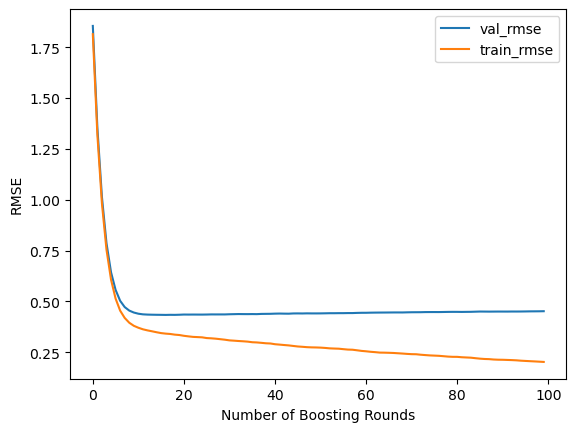

In [ ]:
# Plotting the results
df_xgb_scores.plot.line(ylabel="RMSE", xlabel="Number of Boosting Rounds");

In [53]:
print(f"Best performance: {df_xgb_scores['val_rmse'].min():.4f} at boosting round {df_xgb_scores['val_rmse'].idxmin()}")

Best performance: 0.4337 at boosting round 16


In [55]:
# Change xgb parameter
xgb_params['eta'] = 0.1

eval_scores = {}
model = xgb.train(
    xgb_params, 
    dtrain, 
    evals_result=eval_scores,
    evals=watchlist,
    num_boost_round=100
)

df_xgb_scores = pd.DataFrame([eval_scores['val']["rmse"], eval_scores['train']["rmse"]]).T
df_xgb_scores.columns = ['val_rmse', 'train_rmse']

[0]	train-rmse:2.28944	val-rmse:2.34561
[1]	train-rmse:2.07396	val-rmse:2.12434
[2]	train-rmse:1.88066	val-rmse:1.92600
[3]	train-rmse:1.70730	val-rmse:1.74990
[4]	train-rmse:1.55163	val-rmse:1.59062
[5]	train-rmse:1.41247	val-rmse:1.44984
[6]	train-rmse:1.28795	val-rmse:1.32325
[7]	train-rmse:1.17659	val-rmse:1.20929
[8]	train-rmse:1.07733	val-rmse:1.10827
[9]	train-rmse:0.98877	val-rmse:1.02014
[10]	train-rmse:0.91008	val-rmse:0.94064
[11]	train-rmse:0.84032	val-rmse:0.87118
[12]	train-rmse:0.77860	val-rmse:0.80955
[13]	train-rmse:0.72413	val-rmse:0.75585
[14]	train-rmse:0.67614	val-rmse:0.70868
[15]	train-rmse:0.63380	val-rmse:0.66680
[16]	train-rmse:0.59658	val-rmse:0.63081
[17]	train-rmse:0.56409	val-rmse:0.59975
[18]	train-rmse:0.53570	val-rmse:0.57380
[19]	train-rmse:0.51106	val-rmse:0.55108
[20]	train-rmse:0.48973	val-rmse:0.53137
[21]	train-rmse:0.47141	val-rmse:0.51466
[22]	train-rmse:0.45529	val-rmse:0.50035
[23]	train-rmse:0.44162	val-rmse:0.48842
[24]	train-rmse:0.42957	va

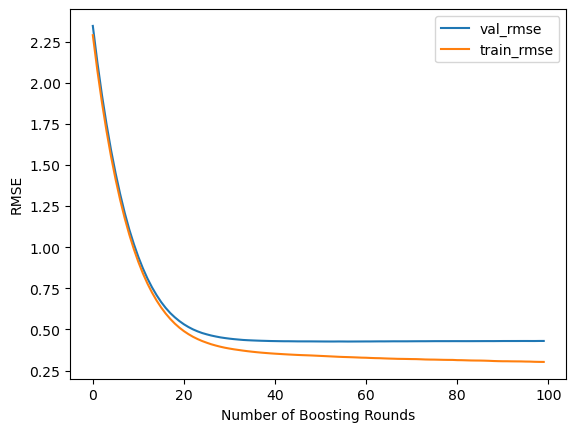

In [56]:
# Plotting the results
df_xgb_scores.plot.line(ylabel="RMSE", xlabel="Number of Boosting Rounds");

In [57]:
print(f"Best performance: {df_xgb_scores['val_rmse'].min():.4f} at boosting round {df_xgb_scores['val_rmse'].idxmin()}")

Best performance: 0.4266 at boosting round 56
